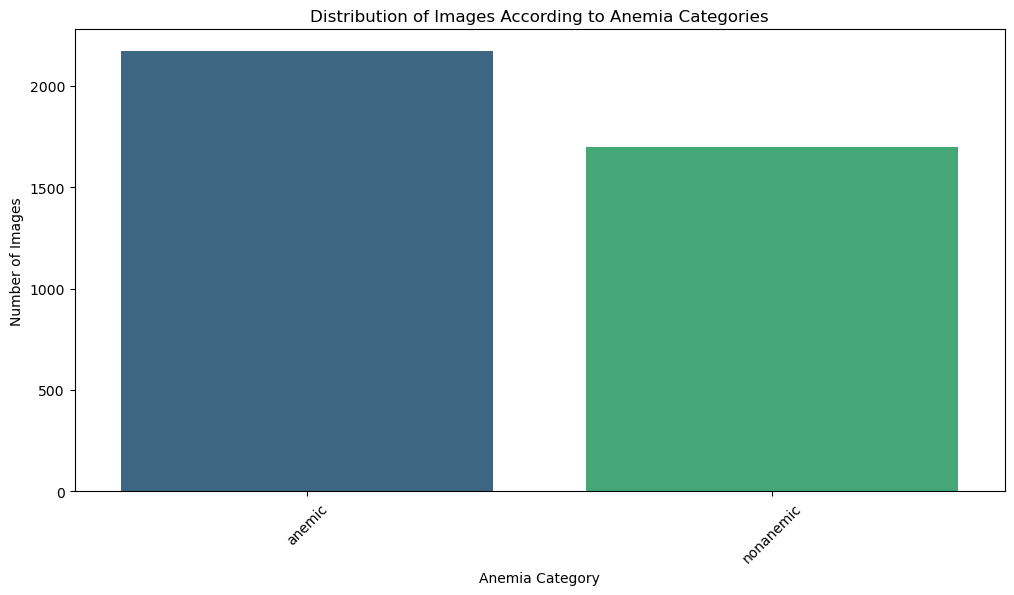

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the path to your data directory
data_dir = "Palm"

# Get the list of waste categories
categories = os.listdir(data_dir)

# Create a dictionary to store the count of images for each category
category_counts = {category: len(os.listdir(os.path.join(data_dir, category))) for category in categories}

# Convert the dictionary to a pandas DataFrame for easier manipulation
df_counts = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count'])

# Plot the distribution of images across categories
plt.figure(figsize=(12, 6))
sns.barplot(x=df_counts.index, y=df_counts['Count'], palette='viridis')
plt.title('Distribution of Images According to Anemia Categories')
plt.xlabel('Anemia Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()



In [2]:
import os
import pandas as pd

# Create lists to store file paths and corresponding target labels
file_paths = []
targets = []

# Iterate through each waste category
for category in categories:
    category_dir = os.path.join(data_dir, category)
    
    # Iterate through each image file in the category directory
    for img_file in os.listdir(category_dir):
        # Construct the file path
        img_path = os.path.join(category_dir, img_file)
        
        # Append the file path and target label to the lists
        file_paths.append(img_path)
        targets.append(category)

# Create a DataFrame from the lists
df = pd.DataFrame({'File_Path': file_paths, 'Target': targets})

In [3]:
df

,File_Path,Target
0,Palm\anemic\Anemic-260 (10).png,anemic
1,Palm\anemic\Anemic-260 (12).png,anemic
2,Palm\anemic\Anemic-260 (2).png,anemic
3,Palm\anemic\Anemic-260 (4).png,anemic
4,Palm\anemic\Anemic-260 (6).png,anemic
...,...,...
3862,Palm\nonanemic\Non-AnemicP-204 (6).png,nonanemic
3863,Palm\nonanemic\Non-AnemicP-204 (7).png,nonanemic
3864,Palm\nonanemic\Non-AnemicP-204 (8).png,nonanemic
3865,Palm\nonanemic\Non-AnemicP-204 (9).png,nonanemic


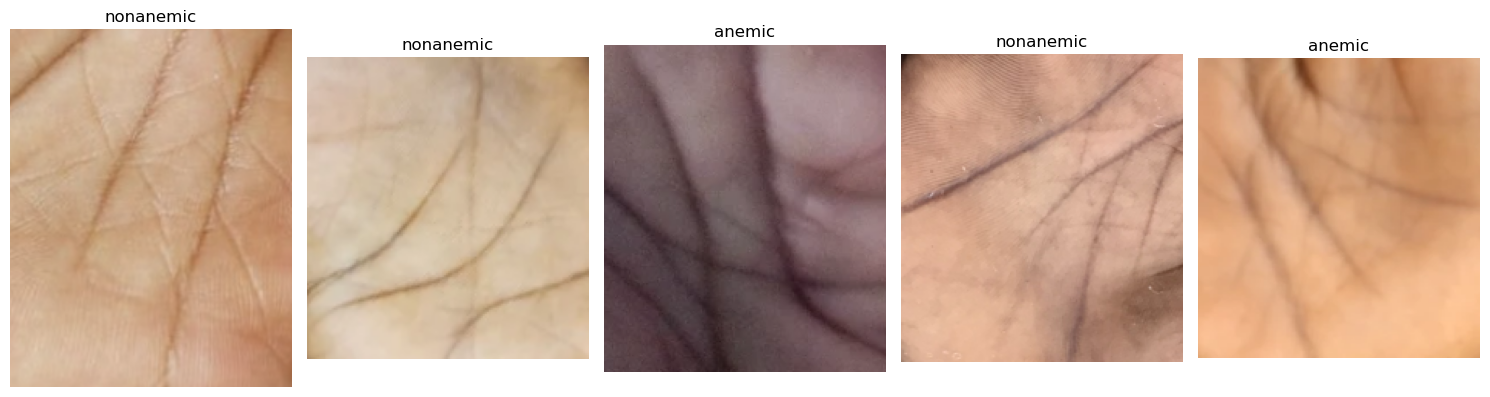

In [4]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Choose the number of random photos to display
num_photos = 5

# Create a figure to display the photos
plt.figure(figsize=(15, 5))

# Iterate through the number of photos to display
for i in range(num_photos):
    # Choose a random waste category
    random_category = random.choice(categories)
    category_dir = os.path.join(data_dir, random_category)
    
    # Choose a random image file from the category directory
    random_img_file = random.choice(os.listdir(category_dir))
    img_path = os.path.join(category_dir, random_img_file)
    
    # Read and display the image
    img = mpimg.imread(img_path)
    plt.subplot(1, num_photos, i+1)
    plt.imshow(img)
    plt.title(random_category)
    plt.axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(3093, 387, 387)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Create training data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='File_Path',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 3093 validated image filenames belonging to 2 classes.


In [8]:
# Create validation data generator
validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='File_Path',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 387 validated image filenames belonging to 2 classes.


In [9]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='File_Path',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 387 validated image filenames belonging to 2 classes.


In [10]:
import time
import matplotlib.pyplot as plt

# MobileNetV2

# Batch Size = 18

Epochs = 15

In [18]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

base_model.trainable = False

model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

end_time = time.time()

processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/15
172/172 [==============================] - 80s 449ms/step - loss: 0.8215 - accuracy: 0.6657 - val_loss: 0.4560 - val_accuracy: 0.7933
Epoch 2/15
172/172 [==============================] - 79s 458ms/step - loss: 0.3144 - accuracy: 0.8655 - val_loss: 0.3733 - val_accuracy: 0.8295
Epoch 3/15
172/172 [==============================] - 77s 446ms/step - loss: 0.1993 - accuracy: 0.9234 - val_loss: 0.2744 - val_accuracy: 0.8992
Epoch 4/15
172/172 [==============================] - 78s 451ms/step - loss: 0.1120 - accuracy: 0.9593 - val_loss: 0.2850 - val_accuracy: 0.8863
Epoch 5/15
172/172 [==============================] - 77s 445ms/step - loss: 0.0991 - accuracy: 0.9622 - val_loss: 0.2566 - val_accuracy: 0.9147
Epoch 6/15
172/172 [==============================] - 76s 444ms/step - loss: 0.0693 - accuracy: 0.9770 - val_loss: 0.3724 - val_accuracy: 0.8786
Epoch 7/15
172/172 [==============================] - 77s 446ms/step - loss: 0.0811 - accuracy: 0.9686 - val_loss: 0.2534 - val_ac

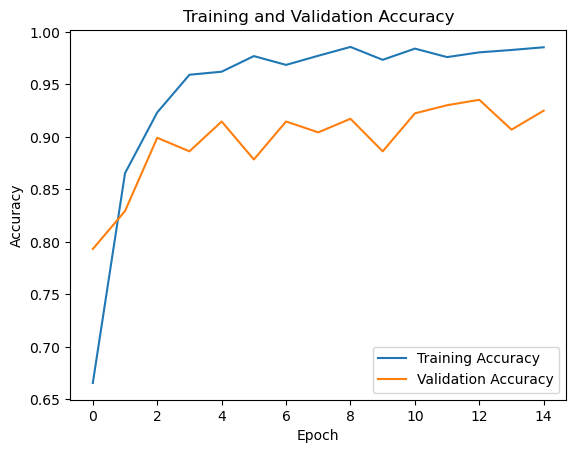

In [19]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 158ms/step
Accuracy: 0.9302325581395349
AUC: 0.9610328764189334
Precision: 0.9757575757575757
Recall: 0.875
Confusion Matrix:
[[199   4]
 [ 23 161]]


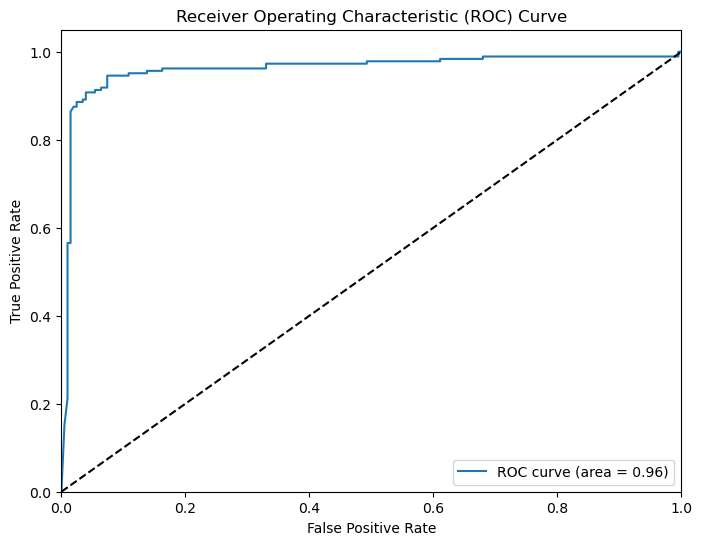

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


Epochs = 25

In [33]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/25
172/172 [==============================] - 82s 461ms/step - loss: 1.1642 - accuracy: 0.6809 - val_loss: 0.4140 - val_accuracy: 0.7984
Epoch 2/25
172/172 [==============================] - 77s 447ms/step - loss: 0.3021 - accuracy: 0.8704 - val_loss: 0.3380 - val_accuracy: 0.8501
Epoch 3/25
172/172 [==============================] - 78s 455ms/step - loss: 0.1958 - accuracy: 0.9247 - val_loss: 0.2416 - val_accuracy: 0.9018
Epoch 4/25
172/172 [==============================] - 78s 453ms/step - loss: 0.1528 - accuracy: 0.9402 - val_loss: 0.2805 - val_accuracy: 0.9096
Epoch 5/25
172/172 [==============================] - 79s 458ms/step - loss: 0.1034 - accuracy: 0.9606 - val_loss: 0.2859 - val_accuracy: 0.9121
Epoch 6/25
172/172 [==============================] - 78s 450ms/step - loss: 0.0896 - accuracy: 0.9677 - val_loss: 0.2122 - val_accuracy: 0.9276
Epoch 7/25
172/172 [==============================] - 78s 451ms/step - loss: 0.0669 - accuracy: 0.9780 - val_loss: 0.2280 - val_ac

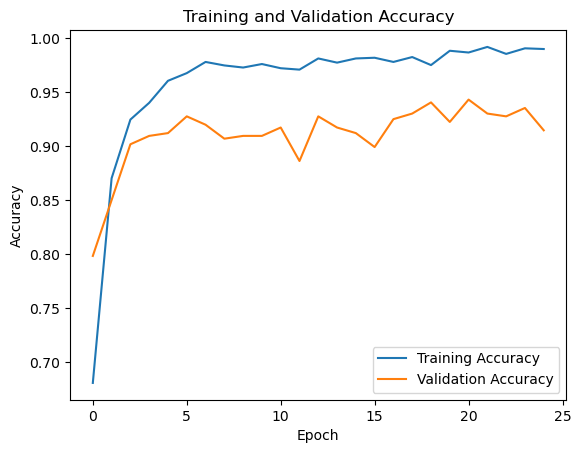

In [34]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 148ms/step
Accuracy: 0.9250645994832042
AUC: 0.9692385949882202
Precision: 0.9015544041450777
Recall: 0.9456521739130435
Confusion Matrix:
[[184  19]
 [ 10 174]]


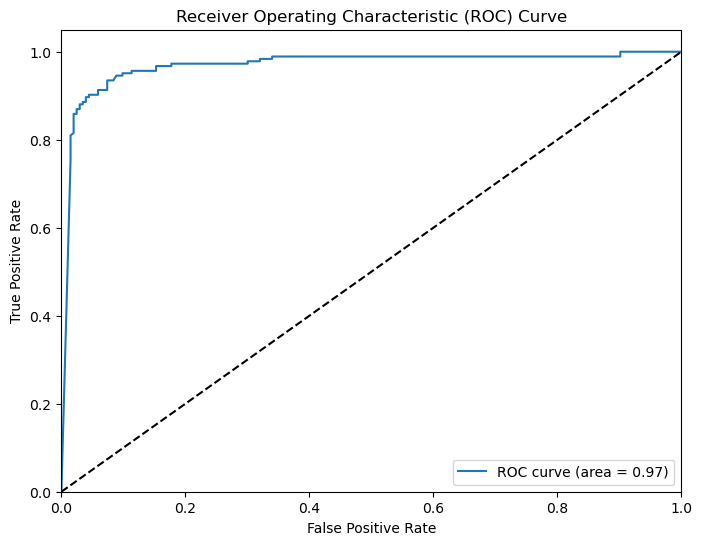

In [35]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


Batch Size = 32

In [45]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/15
97/97 [==============================] - 73s 726ms/step - loss: 0.8829 - accuracy: 0.6253 - val_loss: 0.5895 - val_accuracy: 0.6693
Epoch 2/15
97/97 [==============================] - 69s 711ms/step - loss: 0.4400 - accuracy: 0.7876 - val_loss: 0.3594 - val_accuracy: 0.8295
Epoch 3/15
97/97 [==============================] - 69s 712ms/step - loss: 0.2571 - accuracy: 0.8849 - val_loss: 0.3074 - val_accuracy: 0.8605
Epoch 4/15
97/97 [==============================] - 70s 719ms/step - loss: 0.1592 - accuracy: 0.9334 - val_loss: 0.2158 - val_accuracy: 0.9147
Epoch 5/15
97/97 [==============================] - 69s 713ms/step - loss: 0.1100 - accuracy: 0.9609 - val_loss: 0.2110 - val_accuracy: 0.9276
Epoch 6/15
97/97 [==============================] - 69s 714ms/step - loss: 0.0743 - accuracy: 0.9774 - val_loss: 0.2259 - val_accuracy: 0.9199
Epoch 7/15
97/97 [==============================] - 69s 706ms/step - loss: 0.0639 - accuracy: 0.9816 - val_loss: 0.2179 - val_accuracy: 0.9251

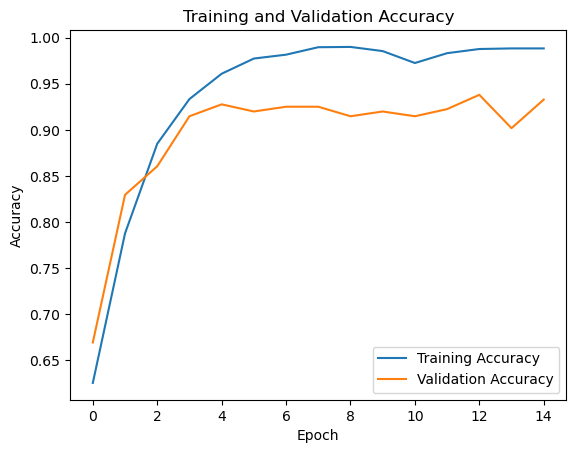

In [46]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy: 0.937984496124031
AUC: 0.9665345898479332
Precision: 0.949438202247191
Recall: 0.9184782608695652
Confusion Matrix:
[[194   9]
 [ 15 169]]


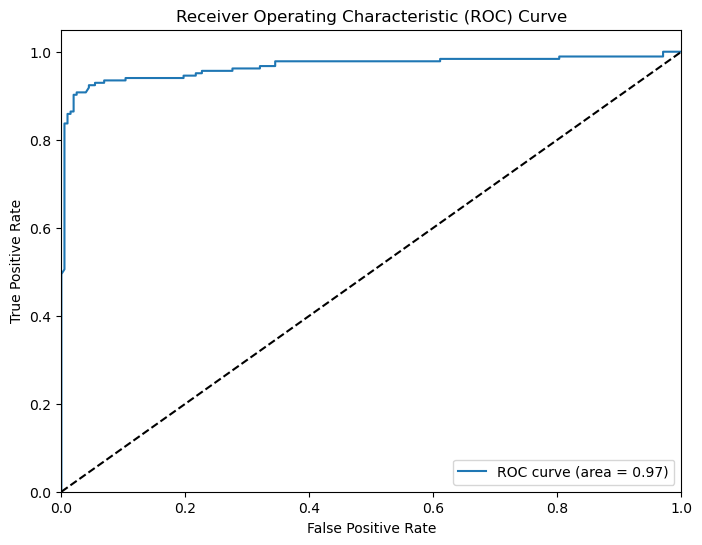

In [47]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [48]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/25
97/97 [==============================] - 78s 784ms/step - loss: 0.8505 - accuracy: 0.6899 - val_loss: 0.4017 - val_accuracy: 0.8320
Epoch 2/25
97/97 [==============================] - 70s 716ms/step - loss: 0.2967 - accuracy: 0.8888 - val_loss: 0.3096 - val_accuracy: 0.8527
Epoch 3/25
97/97 [==============================] - 68s 702ms/step - loss: 0.1600 - accuracy: 0.9428 - val_loss: 0.2109 - val_accuracy: 0.9225
Epoch 4/25
97/97 [==============================] - 69s 707ms/step - loss: 0.0940 - accuracy: 0.9709 - val_loss: 0.2560 - val_accuracy: 0.9121
Epoch 5/25
97/97 [==============================] - 69s 710ms/step - loss: 0.0627 - accuracy: 0.9848 - val_loss: 0.2331 - val_accuracy: 0.9070
Epoch 6/25
97/97 [==============================] - 69s 707ms/step - loss: 0.0579 - accuracy: 0.9855 - val_loss: 0.2505 - val_accuracy: 0.9225
Epoch 7/25
97/97 [==============================] - 68s 704ms/step - loss: 0.0511 - accuracy: 0.9829 - val_loss: 0.2900 - val_accuracy: 0.8966

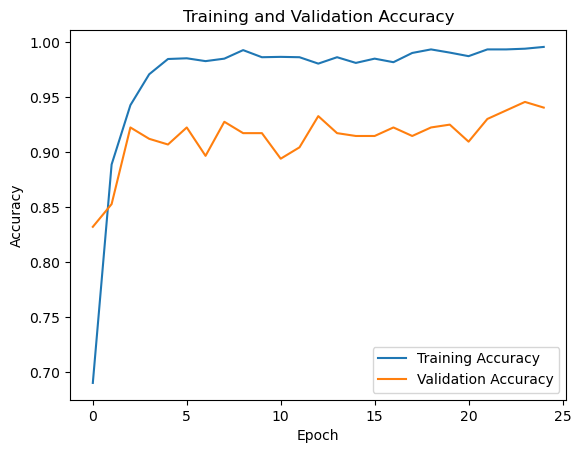

In [49]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 849ms/step
Accuracy: 0.9302325581395349
AUC: 0.9642053973013492
Precision: 0.9243243243243243
Recall: 0.9293478260869565
Confusion Matrix:
[[189  14]
 [ 13 171]]


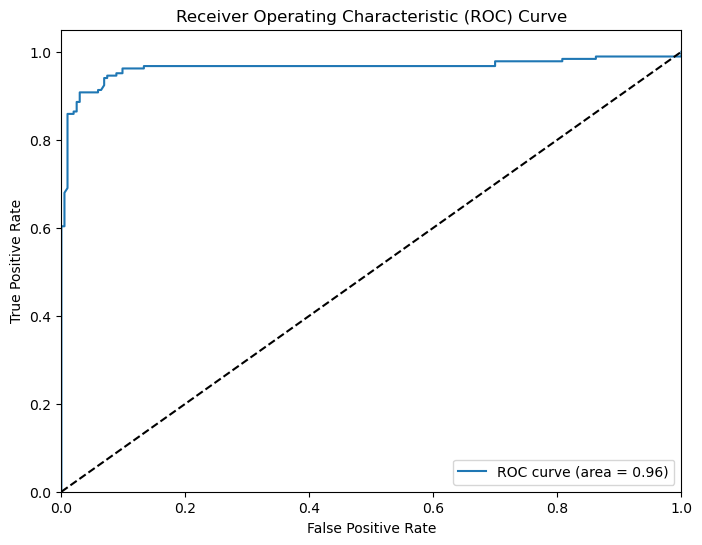

In [50]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [51]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/15
97/97 [==============================] - 71s 708ms/step - loss: 1.0151 - accuracy: 0.6747 - val_loss: 0.4244 - val_accuracy: 0.8295
Epoch 2/15
97/97 [==============================] - 68s 700ms/step - loss: 0.2661 - accuracy: 0.8849 - val_loss: 0.2616 - val_accuracy: 0.8992
Epoch 3/15
97/97 [==============================] - 69s 713ms/step - loss: 0.1569 - accuracy: 0.9382 - val_loss: 0.2304 - val_accuracy: 0.8992
Epoch 4/15
97/97 [==============================] - 68s 700ms/step - loss: 0.1059 - accuracy: 0.9612 - val_loss: 0.2319 - val_accuracy: 0.9044
Epoch 5/15
97/97 [==============================] - 68s 701ms/step - loss: 0.0943 - accuracy: 0.9670 - val_loss: 0.4841 - val_accuracy: 0.8553
Epoch 6/15
97/97 [==============================] - 68s 702ms/step - loss: 0.0810 - accuracy: 0.9715 - val_loss: 0.2227 - val_accuracy: 0.8941
Epoch 7/15
97/97 [==============================] - 68s 702ms/step - loss: 0.0610 - accuracy: 0.9800 - val_loss: 0.2169 - val_accuracy: 0.9276

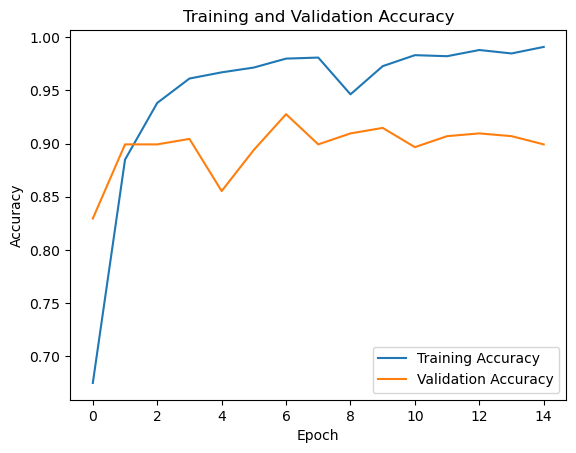

In [52]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy: 0.9276485788113695
AUC: 0.9611801242236025
Precision: 0.9285714285714286
Recall: 0.9184782608695652
Confusion Matrix:
[[190  13]
 [ 15 169]]


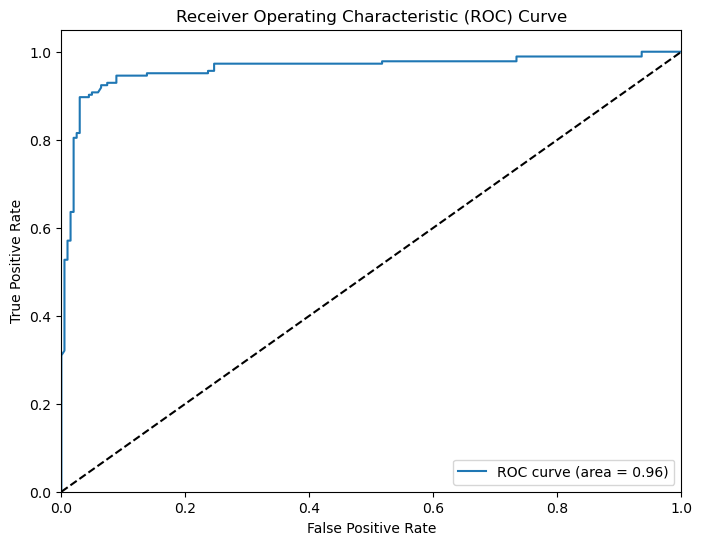

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [54]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/25
97/97 [==============================] - 71s 707ms/step - loss: 0.9074 - accuracy: 0.5409 - val_loss: 0.6881 - val_accuracy: 0.6047
Epoch 2/25
97/97 [==============================] - 68s 699ms/step - loss: 0.6765 - accuracy: 0.6130 - val_loss: 0.6499 - val_accuracy: 0.6899
Epoch 3/25
97/97 [==============================] - 68s 704ms/step - loss: 0.6081 - accuracy: 0.7022 - val_loss: 0.6114 - val_accuracy: 0.7158
Epoch 4/25
97/97 [==============================] - 68s 701ms/step - loss: 0.5480 - accuracy: 0.7559 - val_loss: 0.5751 - val_accuracy: 0.7623
Epoch 5/25
97/97 [==============================] - 68s 700ms/step - loss: 0.4943 - accuracy: 0.8073 - val_loss: 0.5308 - val_accuracy: 0.7829
Epoch 6/25
97/97 [==============================] - 68s 701ms/step - loss: 0.4436 - accuracy: 0.8396 - val_loss: 0.4880 - val_accuracy: 0.8372
Epoch 7/25
97/97 [==============================] - 68s 705ms/step - loss: 0.4177 - accuracy: 0.8532 - val_loss: 0.4736 - val_accuracy: 0.8295

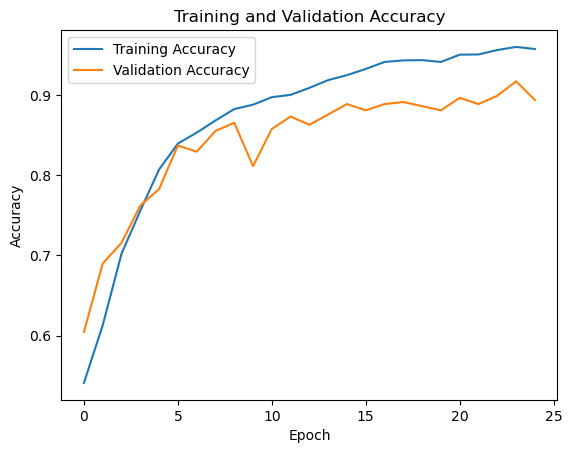

In [55]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy: 0.8733850129198967
AUC: 0.9032715784964661
Precision: 0.9041916167664671
Recall: 0.8206521739130435
Confusion Matrix:
[[187  16]
 [ 33 151]]


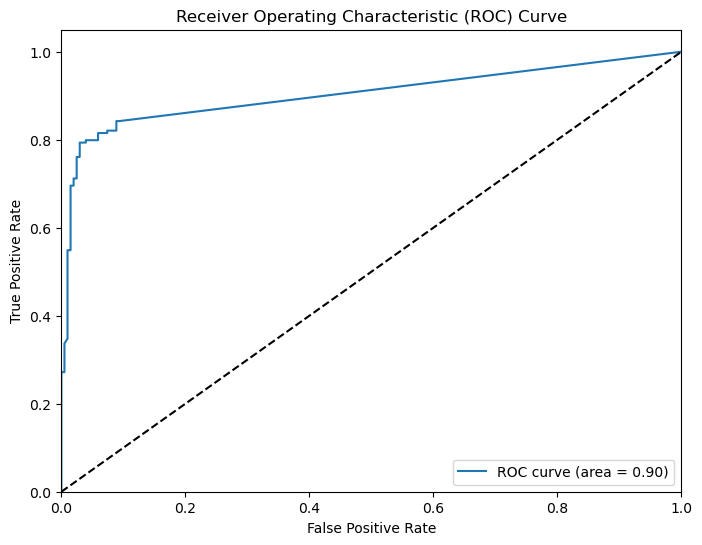

In [56]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [57]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/15
97/97 [==============================] - 71s 711ms/step - loss: 0.8892 - accuracy: 0.6815 - val_loss: 0.4661 - val_accuracy: 0.7855
Epoch 2/15
97/97 [==============================] - 68s 698ms/step - loss: 0.2926 - accuracy: 0.8898 - val_loss: 0.2644 - val_accuracy: 0.9044
Epoch 3/15
97/97 [==============================] - 68s 700ms/step - loss: 0.1862 - accuracy: 0.9344 - val_loss: 0.2420 - val_accuracy: 0.9018
Epoch 4/15
97/97 [==============================] - 68s 703ms/step - loss: 0.1110 - accuracy: 0.9654 - val_loss: 0.1913 - val_accuracy: 0.9251
Epoch 5/15
97/97 [==============================] - 68s 703ms/step - loss: 0.0741 - accuracy: 0.9796 - val_loss: 0.1976 - val_accuracy: 0.9199
Epoch 6/15
97/97 [==============================] - 68s 703ms/step - loss: 0.0676 - accuracy: 0.9790 - val_loss: 0.1953 - val_accuracy: 0.9302
Epoch 7/15
97/97 [==============================] - 68s 702ms/step - loss: 0.0539 - accuracy: 0.9851 - val_loss: 0.2544 - val_accuracy: 0.9070

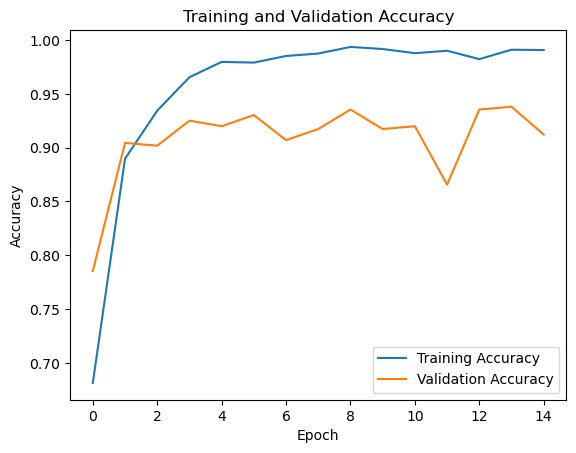

In [58]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 893ms/step
Accuracy: 0.9095607235142119
AUC: 0.9641652388091668
Precision: 0.8599033816425121
Recall: 0.967391304347826
Confusion Matrix:
[[174  29]
 [  6 178]]


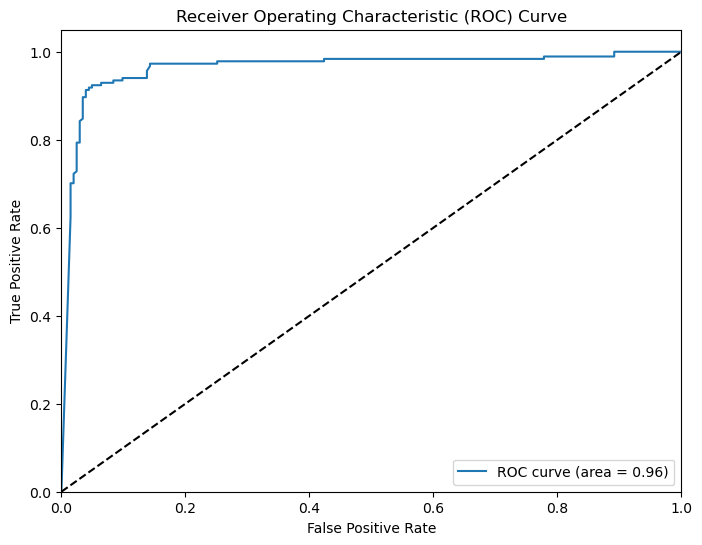

In [59]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [60]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/25
97/97 [==============================] - 72s 715ms/step - loss: 0.9777 - accuracy: 0.6570 - val_loss: 0.4865 - val_accuracy: 0.7649
Epoch 2/25
97/97 [==============================] - 68s 705ms/step - loss: 0.3718 - accuracy: 0.8435 - val_loss: 0.3386 - val_accuracy: 0.8630
Epoch 3/25
97/97 [==============================] - 68s 703ms/step - loss: 0.2031 - accuracy: 0.9256 - val_loss: 0.2296 - val_accuracy: 0.9018
Epoch 4/25
97/97 [==============================] - 68s 705ms/step - loss: 0.1251 - accuracy: 0.9596 - val_loss: 0.2034 - val_accuracy: 0.9276
Epoch 5/25
97/97 [==============================] - 69s 706ms/step - loss: 0.0879 - accuracy: 0.9735 - val_loss: 0.2011 - val_accuracy: 0.9251
Epoch 6/25
97/97 [==============================] - 68s 705ms/step - loss: 0.0575 - accuracy: 0.9848 - val_loss: 0.1850 - val_accuracy: 0.9251
Epoch 7/25
97/97 [==============================] - 69s 710ms/step - loss: 0.0492 - accuracy: 0.9877 - val_loss: 0.1950 - val_accuracy: 0.9199

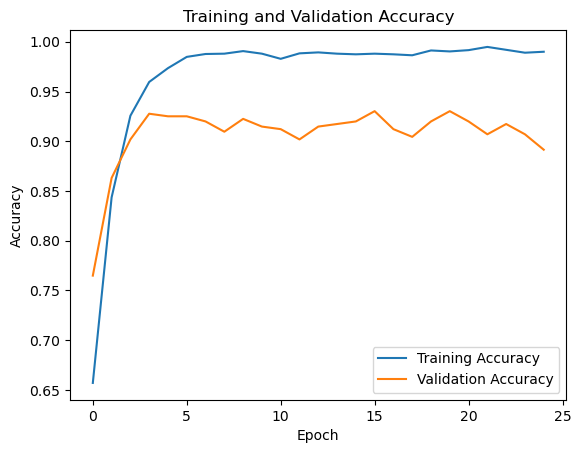

In [61]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy: 0.8992248062015504
AUC: 0.9561469265367317
Precision: 0.9447852760736196
Recall: 0.8369565217391305
Confusion Matrix:
[[194   9]
 [ 30 154]]


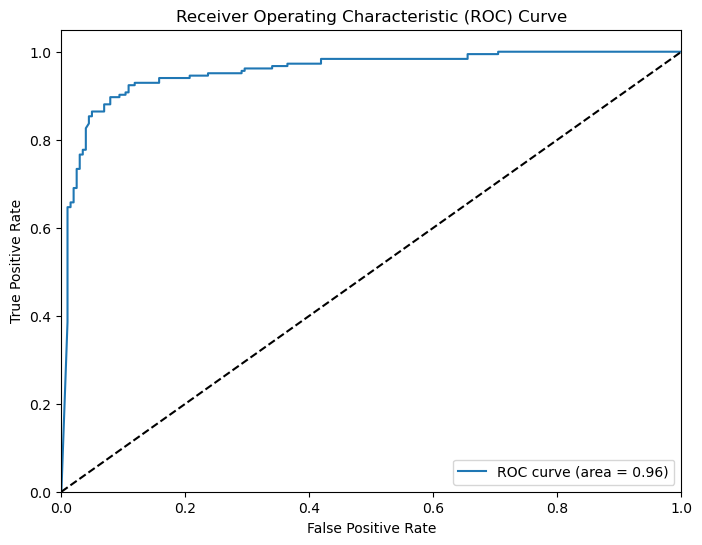

In [62]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


# CNN

In [69]:
#batch size = 128
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


start_time = time.time()

# Create and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/15
25/25 [==============================] - 175s 6s/step - loss: 0.7016 - accuracy: 0.5377 - val_loss: 0.6807 - val_accuracy: 0.5969
Epoch 2/15
25/25 [==============================] - 126s 5s/step - loss: 0.6812 - accuracy: 0.5609 - val_loss: 0.6639 - val_accuracy: 0.5969
Epoch 3/15
25/25 [==============================] - 132s 5s/step - loss: 0.6687 - accuracy: 0.5703 - val_loss: 0.6309 - val_accuracy: 0.6227
Epoch 4/15
25/25 [==============================] - 141s 6s/step - loss: 0.6478 - accuracy: 0.6036 - val_loss: 0.6731 - val_accuracy: 0.5220
Epoch 5/15
25/25 [==============================] - 122s 5s/step - loss: 0.6397 - accuracy: 0.6043 - val_loss: 0.6419 - val_accuracy: 0.6460
Epoch 6/15
25/25 [==============================] - 122s 5s/step - loss: 0.6607 - accuracy: 0.5713 - val_loss: 0.6405 - val_accuracy: 0.6047
Epoch 7/15
25/25 [==============================] - 120s 5s/step - loss: 0.6565 - accuracy: 0.6007 - val_loss: 0.6142 - val_accuracy: 0.6744
Epoch 8/15
25

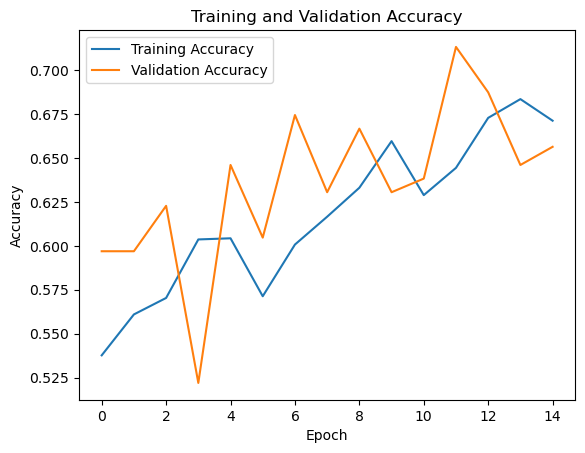

In [70]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 214ms/step
Accuracy: 0.6227390180878553
AUC: 0.6798297279931462
Precision: 0.5887850467289719
Recall: 0.6847826086956522
Confusion Matrix:
[[115  88]
 [ 58 126]]


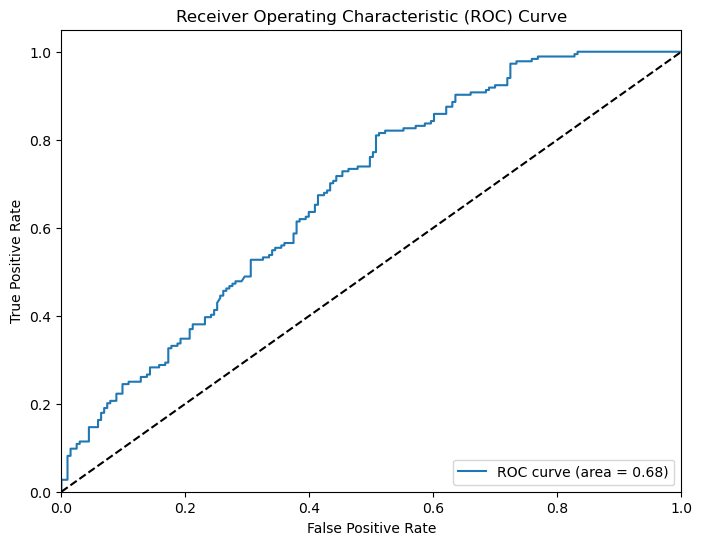

In [71]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [92]:
#batch size = 32
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/15
97/97 [==============================] - 140s 1s/step - loss: 0.6922 - accuracy: 0.5571 - val_loss: 0.6680 - val_accuracy: 0.5969
Epoch 2/15
97/97 [==============================] - 148s 2s/step - loss: 0.6725 - accuracy: 0.5609 - val_loss: 0.6938 - val_accuracy: 0.5969
Epoch 3/15
97/97 [==============================] - 124s 1s/step - loss: 0.6798 - accuracy: 0.5558 - val_loss: 0.6881 - val_accuracy: 0.5969
Epoch 4/15
97/97 [==============================] - 131s 1s/step - loss: 0.6842 - accuracy: 0.5584 - val_loss: 0.6788 - val_accuracy: 0.6021
Epoch 5/15
97/97 [==============================] - 131s 1s/step - loss: 0.6740 - accuracy: 0.5726 - val_loss: 0.6588 - val_accuracy: 0.6124
Epoch 6/15
97/97 [==============================] - 113s 1s/step - loss: 0.6828 - accuracy: 0.5619 - val_loss: 0.6747 - val_accuracy: 0.5969
Epoch 7/15
97/97 [==============================] - 113s 1s/step - loss: 0.6682 - accuracy: 0.5900 - val_loss: 0.6553 - val_accuracy: 0.6305
Epoch 8/15
97

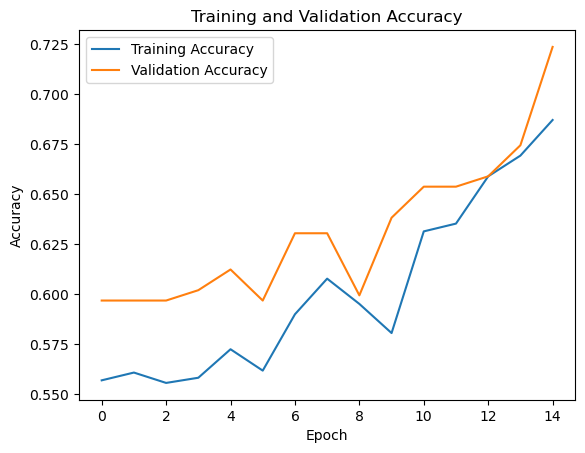

In [93]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 122ms/step
Accuracy: 0.6124031007751938
AUC: 0.70433979438852
Precision: 0.7361111111111112
Recall: 0.28804347826086957
Confusion Matrix:
[[184  19]
 [131  53]]


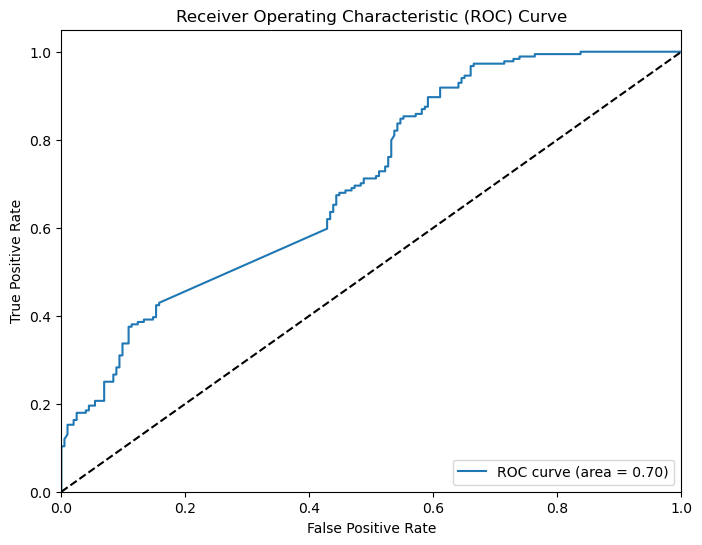

In [94]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [95]:
#batch size = 32
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/25
97/97 [==============================] - 123s 1s/step - loss: 0.6879 - accuracy: 0.5564 - val_loss: 0.6864 - val_accuracy: 0.5969
Epoch 2/25
97/97 [==============================] - 113s 1s/step - loss: 0.6864 - accuracy: 0.5609 - val_loss: 0.6853 - val_accuracy: 0.5969
Epoch 3/25
97/97 [==============================] - 114s 1s/step - loss: 0.6677 - accuracy: 0.5800 - val_loss: 0.6393 - val_accuracy: 0.6305
Epoch 4/25
97/97 [==============================] - 115s 1s/step - loss: 0.6499 - accuracy: 0.6023 - val_loss: 0.6236 - val_accuracy: 0.6408
Epoch 5/25
97/97 [==============================] - 112s 1s/step - loss: 0.6332 - accuracy: 0.6272 - val_loss: 0.6174 - val_accuracy: 0.6460
Epoch 6/25
97/97 [==============================] - 114s 1s/step - loss: 0.6174 - accuracy: 0.6363 - val_loss: 0.5945 - val_accuracy: 0.6770
Epoch 7/25
97/97 [==============================] - 112s 1s/step - loss: 0.6207 - accuracy: 0.6424 - val_loss: 0.6410 - val_accuracy: 0.6408
Epoch 8/25
97

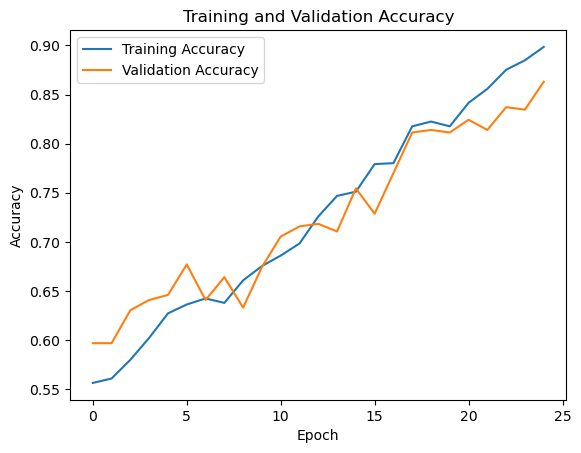

In [96]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 149ms/step
Accuracy: 0.8656330749354005
AUC: 0.9334439922895695
Precision: 0.8473684210526315
Recall: 0.875
Confusion Matrix:
[[174  29]
 [ 23 161]]


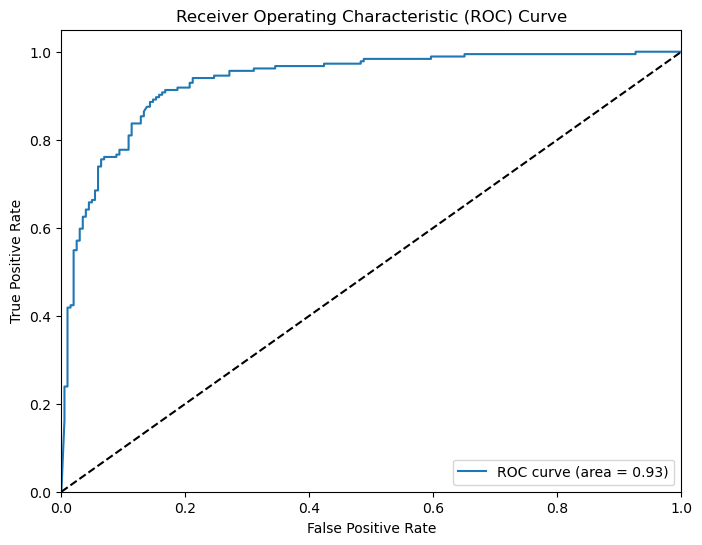

In [97]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [98]:
#batch size = 32
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=13,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/13
97/97 [==============================] - 116s 1s/step - loss: 0.6782 - accuracy: 0.5593 - val_loss: 0.6744 - val_accuracy: 0.4935
Epoch 2/13
97/97 [==============================] - 113s 1s/step - loss: 0.6685 - accuracy: 0.5732 - val_loss: 0.6451 - val_accuracy: 0.5969
Epoch 3/13
97/97 [==============================] - 113s 1s/step - loss: 0.6879 - accuracy: 0.5584 - val_loss: 0.6745 - val_accuracy: 0.5969
Epoch 4/13
97/97 [==============================] - 112s 1s/step - loss: 0.6784 - accuracy: 0.5535 - val_loss: 0.6760 - val_accuracy: 0.5969
Epoch 5/13
97/97 [==============================] - 112s 1s/step - loss: 0.6841 - accuracy: 0.5629 - val_loss: 0.6716 - val_accuracy: 0.5969
Epoch 6/13
97/97 [==============================] - 113s 1s/step - loss: 0.6743 - accuracy: 0.5603 - val_loss: 0.6592 - val_accuracy: 0.5969
Epoch 7/13
97/97 [==============================] - 112s 1s/step - loss: 0.6545 - accuracy: 0.6036 - val_loss: 0.6549 - val_accuracy: 0.5711
Epoch 8/13
97

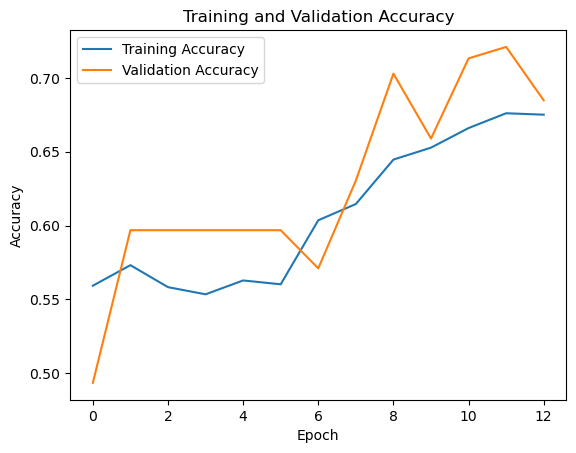

In [99]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 156ms/step
Accuracy: 0.6330749354005168
AUC: 0.7121707003641036
Precision: 0.675
Recall: 0.44021739130434784
Confusion Matrix:
[[164  39]
 [103  81]]


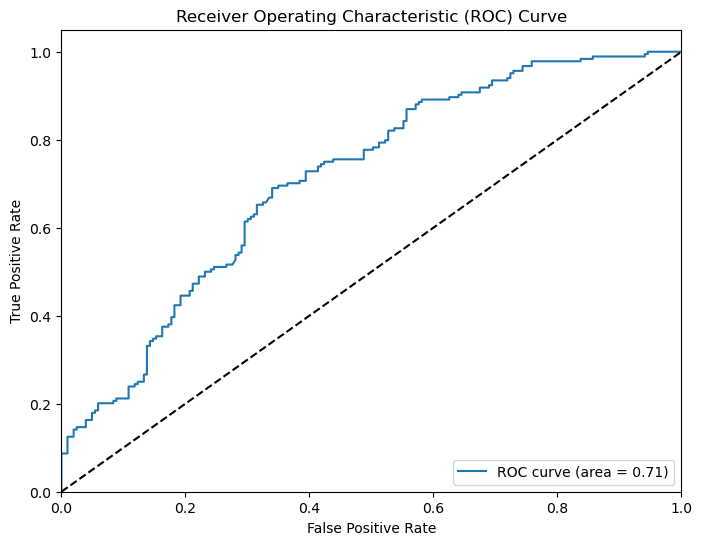

In [100]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [105]:
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

start_time = time.time()

# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu',  input_shape=(img_height, img_width, 3)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(len(train_generator.class_indices), activation='sigmoid'))  # Use 1 unit and 'sigmoid' activation for binary classification


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/15
97/97 [==============================] - 212s 2s/step - loss: 5.1919 - accuracy: 0.4850 - val_loss: 0.7003 - val_accuracy: 0.5840
Epoch 2/15
97/97 [==============================] - 206s 2s/step - loss: 0.6922 - accuracy: 0.5587 - val_loss: 0.6754 - val_accuracy: 0.5969
Epoch 3/15
97/97 [==============================] - 212s 2s/step - loss: 0.6850 - accuracy: 0.5609 - val_loss: 0.6699 - val_accuracy: 0.5969
Epoch 4/15
97/97 [==============================] - 191s 2s/step - loss: 0.6818 - accuracy: 0.5648 - val_loss: 0.6694 - val_accuracy: 0.6227
Epoch 5/15
97/97 [==============================] - 188s 2s/step - loss: 0.6732 - accuracy: 0.5771 - val_loss: 0.6525 - val_accuracy: 0.6305
Epoch 6/15
97/97 [==============================] - 187s 2s/step - loss: 0.7396 - accuracy: 0.5823 - val_loss: 0.6803 - val_accuracy: 0.5969
Epoch 7/15
97/97 [==============================] - 187s 2s/step - loss: 0.6943 - accuracy: 0.5635 - val_loss: 0.6775 - val_accuracy: 0.6021
Epoch 8/15
97

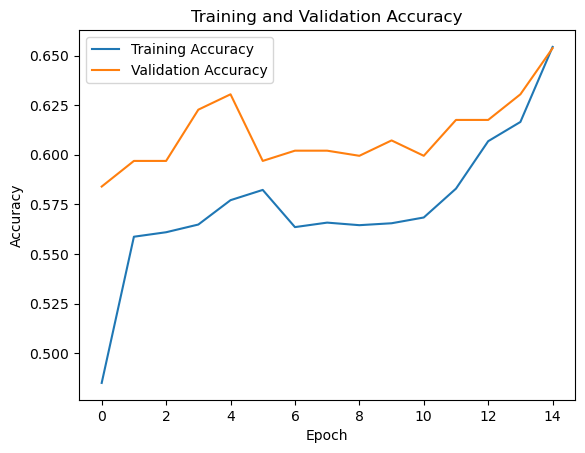

In [106]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 240ms/step
Accuracy: 0.5607235142118863
AUC: 0.7215544013707431
Precision: 0.6166666666666667
Recall: 0.20108695652173914
Confusion Matrix:
[[180  23]
 [147  37]]


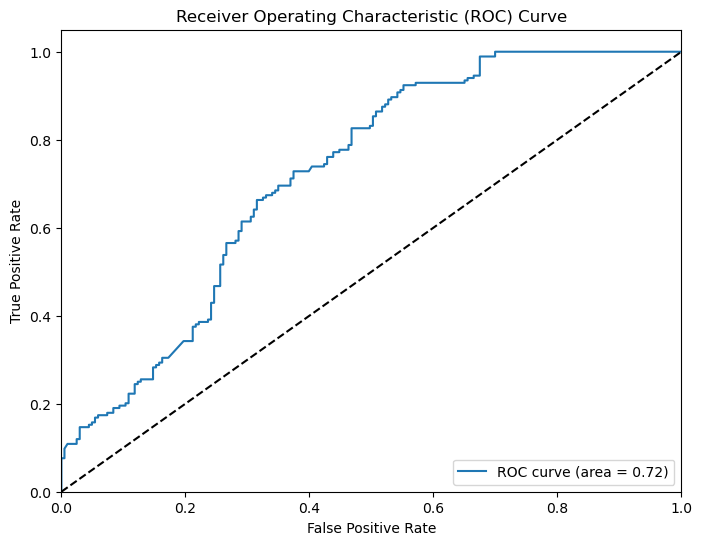

In [107]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [108]:
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

start_time = time.time()

# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu',  input_shape=(img_height, img_width, 3)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(len(train_generator.class_indices), activation='sigmoid'))  # Use 1 unit and 'sigmoid' activation for binary classification


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/25
97/97 [==============================] - 238s 2s/step - loss: 3.6274 - accuracy: 0.5438 - val_loss: 0.6692 - val_accuracy: 0.6047
Epoch 2/25
97/97 [==============================] - 229s 2s/step - loss: 0.6483 - accuracy: 0.6402 - val_loss: 0.6044 - val_accuracy: 0.6589
Epoch 3/25
97/97 [==============================] - 228s 2s/step - loss: 0.5673 - accuracy: 0.7300 - val_loss: 0.5718 - val_accuracy: 0.6873
Epoch 4/25
97/97 [==============================] - 226s 2s/step - loss: 0.5470 - accuracy: 0.7468 - val_loss: 0.5165 - val_accuracy: 0.7158
Epoch 5/25
97/97 [==============================] - 225s 2s/step - loss: 0.4375 - accuracy: 0.8057 - val_loss: 0.5853 - val_accuracy: 0.7106
Epoch 6/25
97/97 [==============================] - 332s 3s/step - loss: 0.3965 - accuracy: 0.8332 - val_loss: 0.4865 - val_accuracy: 0.7261
Epoch 7/25
97/97 [==============================] - 314s 3s/step - loss: 0.3620 - accuracy: 0.8539 - val_loss: 0.5105 - val_accuracy: 0.7494
Epoch 8/25
97

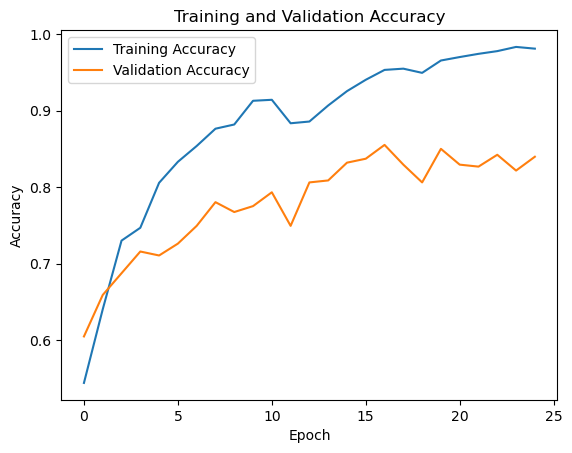

In [109]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 183ms/step
Accuracy: 0.8604651162790697
AUC: 0.9105804240736775
Precision: 0.8735632183908046
Recall: 0.8260869565217391
Confusion Matrix:
[[181  22]
 [ 32 152]]


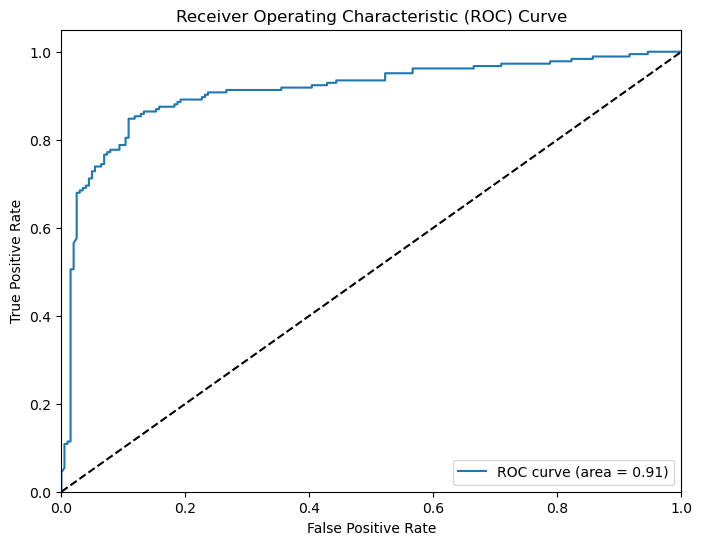

In [110]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


# VGG16

In [111]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Define input dimensions
img_height, img_width = 224, 224  # VGG16 expects input images of size 224x224

# Load VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=13,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/13
97/97 [==============================] - 650s 7s/step - loss: 0.6903 - accuracy: 0.6052 - val_loss: 0.6011 - val_accuracy: 0.6744
Epoch 2/13
97/97 [==============================] - 578s 6s/step - loss: 0.6083 - accuracy: 0.6612 - val_loss: 0.5618 - val_accuracy: 0.6848
Epoch 3/13
97/97 [==============================] - 577s 6s/step - loss: 0.5401 - accuracy: 0.7236 - val_loss: 0.5041 - val_accuracy: 0.7571
Epoch 4/13
97/97 [==============================] - 579s 6s/step - loss: 0.5452 - accuracy: 0.7139 - val_loss: 0.6085 - val_accuracy: 0.6434
Epoch 5/13
97/97 [==============================] - 578s 6s/step - loss: 0.5096 - accuracy: 0.7368 - val_loss: 0.4683 - val_accuracy: 0.7855
Epoch 6/13
97/97 [==============================] - 572s 6s/step - loss: 0.4614 - accuracy: 0.7750 - val_loss: 0.4941 - val_accuracy: 0.7442
Epoch 7/13
97/97 [==============================] - 575s 6s/step - loss: 0.4685 - accuracy: 0.7624 - val_loss: 0.4357 - val_accuracy: 0.8243
Epoch 8/13
97

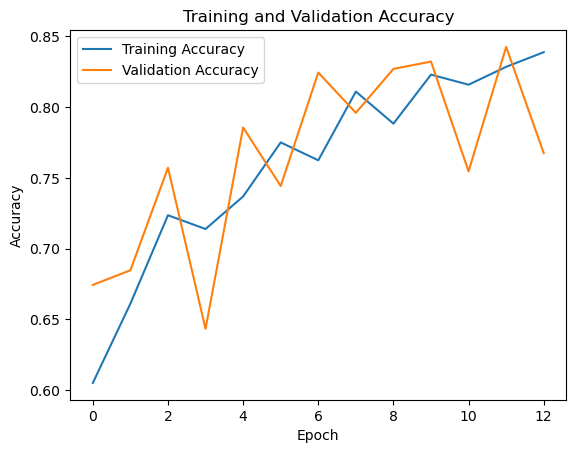

In [112]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 734ms/step
Accuracy: 0.751937984496124
AUC: 0.9094292139644463
Precision: 0.6788617886178862
Recall: 0.907608695652174
Confusion Matrix:
[[124  79]
 [ 17 167]]


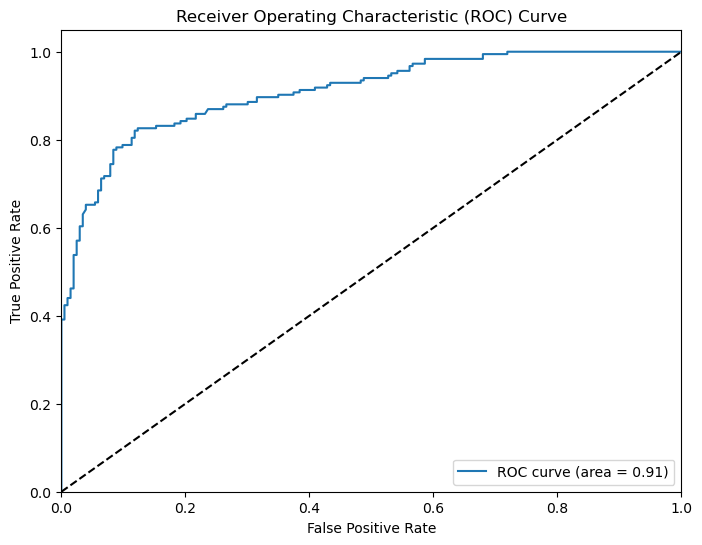

In [113]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

In [114]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Define input dimensions
img_height, img_width = 224, 224  # VGG16 expects input images of size 224x224

# Load VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=13,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/13
97/97 [==============================] - 579s 6s/step - loss: 0.7397 - accuracy: 0.5703 - val_loss: 0.6478 - val_accuracy: 0.6486
Epoch 2/13
97/97 [==============================] - 575s 6s/step - loss: 0.6459 - accuracy: 0.6463 - val_loss: 0.6082 - val_accuracy: 0.7080
Epoch 3/13
97/97 [==============================] - 576s 6s/step - loss: 0.6153 - accuracy: 0.6802 - val_loss: 0.5713 - val_accuracy: 0.7261
Epoch 4/13
97/97 [==============================] - 580s 6s/step - loss: 0.5596 - accuracy: 0.7177 - val_loss: 0.5388 - val_accuracy: 0.7209
Epoch 5/13
97/97 [==============================] - 575s 6s/step - loss: 0.5203 - accuracy: 0.7472 - val_loss: 0.5116 - val_accuracy: 0.7519
Epoch 6/13
97/97 [==============================] - 599s 6s/step - loss: 0.4867 - accuracy: 0.7562 - val_loss: 0.5827 - val_accuracy: 0.6718
Epoch 7/13
97/97 [==============================] - 586s 6s/step - loss: 0.4759 - accuracy: 0.7704 - val_loss: 0.5529 - val_accuracy: 0.6951
Epoch 8/13
97

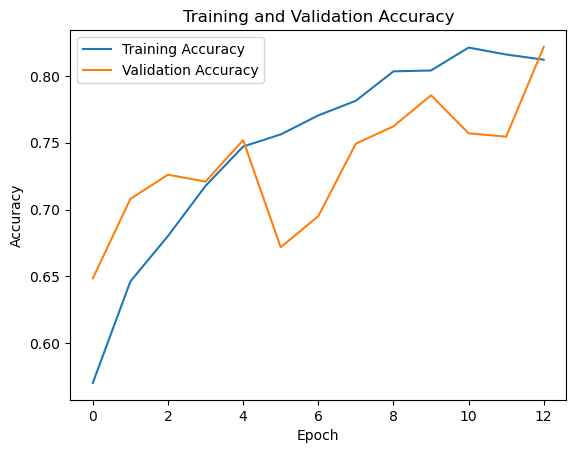

In [115]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 750ms/step
Accuracy: 0.8036175710594315
AUC: 0.8936067680445493
Precision: 0.921875
Recall: 0.6413043478260869
Confusion Matrix:
[[193  10]
 [ 66 118]]


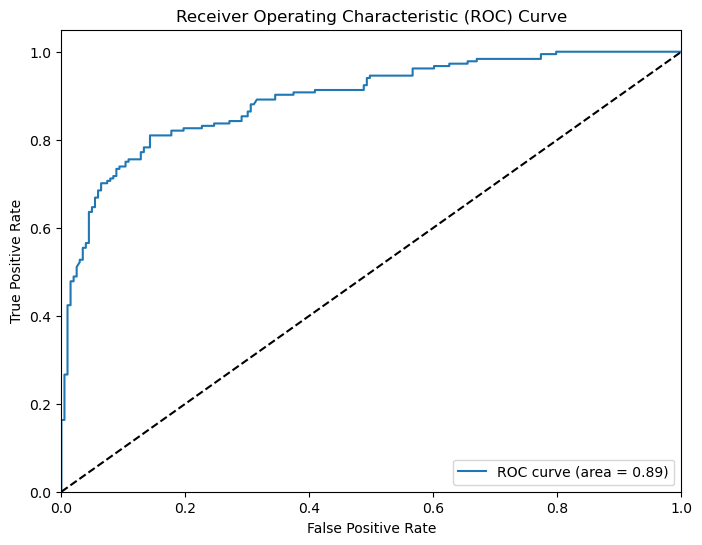

In [116]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

In [117]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Define input dimensions
img_height, img_width = 224, 224  # VGG16 expects input images of size 224x224

# Load VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/25
97/97 [==============================] - 575s 6s/step - loss: 0.7157 - accuracy: 0.6078 - val_loss: 0.6114 - val_accuracy: 0.6693
Epoch 2/25
97/97 [==============================] - 572s 6s/step - loss: 0.5893 - accuracy: 0.6954 - val_loss: 0.5312 - val_accuracy: 0.7468
Epoch 3/25
97/97 [==============================] - 578s 6s/step - loss: 0.5405 - accuracy: 0.7213 - val_loss: 0.5039 - val_accuracy: 0.7804
Epoch 4/25
97/97 [==============================] - 573s 6s/step - loss: 0.5081 - accuracy: 0.7433 - val_loss: 0.4877 - val_accuracy: 0.7700
Epoch 5/25
97/97 [==============================] - 574s 6s/step - loss: 0.4740 - accuracy: 0.7653 - val_loss: 0.4604 - val_accuracy: 0.7855
Epoch 6/25
97/97 [==============================] - 575s 6s/step - loss: 0.4581 - accuracy: 0.7850 - val_loss: 0.4392 - val_accuracy: 0.8088
Epoch 7/25
97/97 [==============================] - 575s 6s/step - loss: 0.4226 - accuracy: 0.8038 - val_loss: 0.4206 - val_accuracy: 0.8217
Epoch 8/25
97

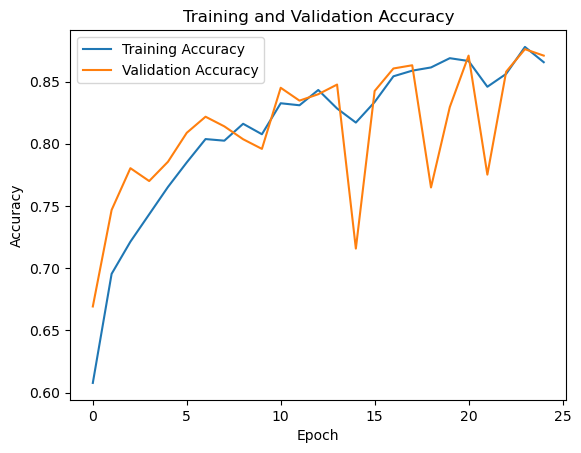

In [118]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 765ms/step
Accuracy: 0.8320413436692506
AUC: 0.9268044549153995
Precision: 0.7793427230046949
Recall: 0.9021739130434783
Confusion Matrix:
[[156  47]
 [ 18 166]]


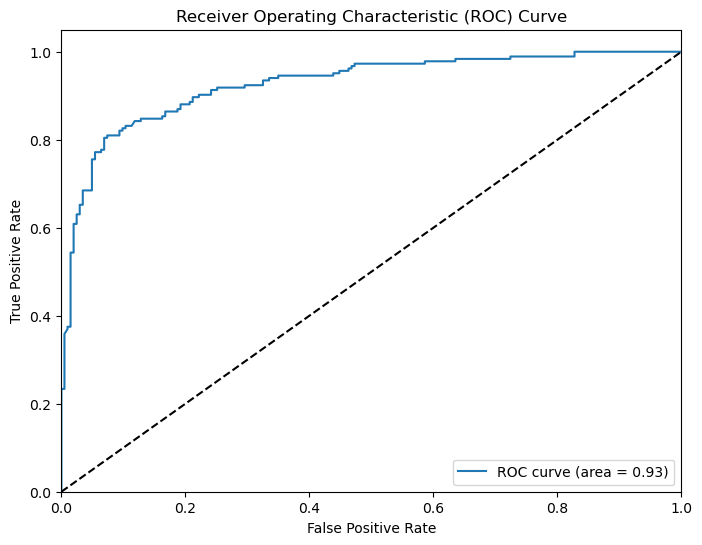

In [119]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

# InceptionV3

In [120]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3  # Import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Define input dimensions
img_height, img_width = 224, 224  

# Load InceptionV3 base model (pre-trained on ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")


Epoch 1/25
97/97 [==============================] - 134s 1s/step - loss: 1.0022 - accuracy: 0.5383 - val_loss: 0.6913 - val_accuracy: 0.5943
Epoch 2/25
97/97 [==============================] - 126s 1s/step - loss: 0.6739 - accuracy: 0.5839 - val_loss: 0.6462 - val_accuracy: 0.6202
Epoch 3/25
97/97 [==============================] - 127s 1s/step - loss: 0.5983 - accuracy: 0.6880 - val_loss: 0.5690 - val_accuracy: 0.6899
Epoch 4/25
97/97 [==============================] - 127s 1s/step - loss: 0.4828 - accuracy: 0.7685 - val_loss: 0.4556 - val_accuracy: 0.8036
Epoch 5/25
97/97 [==============================] - 126s 1s/step - loss: 0.3687 - accuracy: 0.8316 - val_loss: 0.3783 - val_accuracy: 0.8217
Epoch 6/25
97/97 [==============================] - 127s 1s/step - loss: 0.2573 - accuracy: 0.8797 - val_loss: 0.3295 - val_accuracy: 0.8475
Epoch 7/25
97/97 [==============================] - 127s 1s/step - loss: 0.1863 - accuracy: 0.9185 - val_loss: 0.2632 - val_accuracy: 0.8863
Epoch 8/25
97

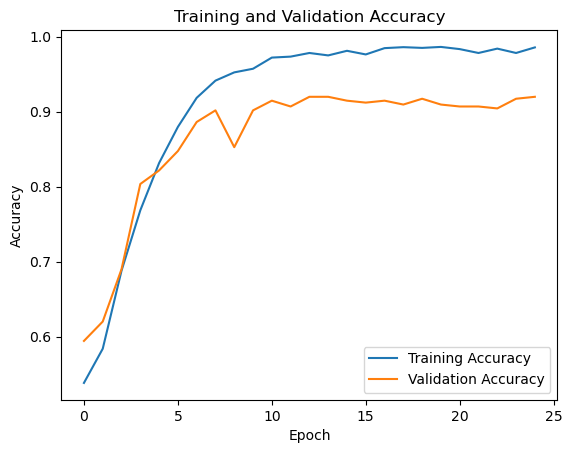

In [121]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step
Accuracy: 0.8992248062015504
AUC: 0.9624919683015635
Precision: 0.9190751445086706
Recall: 0.8641304347826086
Confusion Matrix:
[[189  14]
 [ 25 159]]


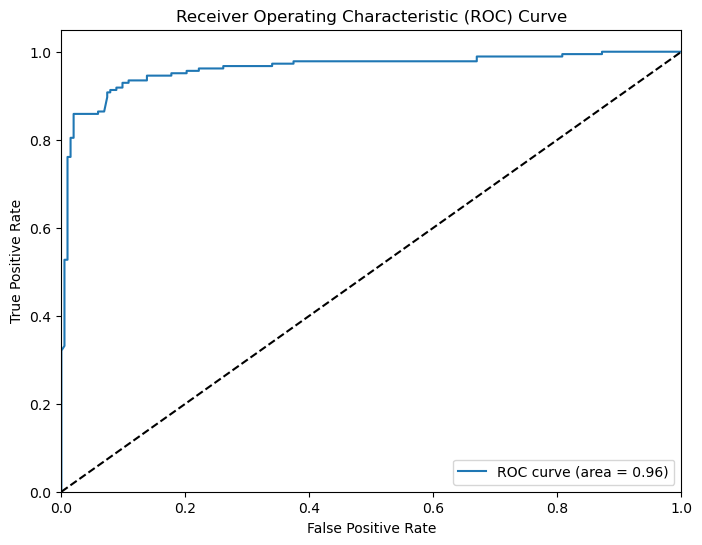

In [122]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

In [123]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3  # Import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Define input dimensions
img_height, img_width = 224, 224  

# Load InceptionV3 base model (pre-trained on ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/15
97/97 [==============================] - 134s 1s/step - loss: 0.9587 - accuracy: 0.6731 - val_loss: 0.4311 - val_accuracy: 0.8165
Epoch 2/15
97/97 [==============================] - 126s 1s/step - loss: 0.3656 - accuracy: 0.8338 - val_loss: 0.3337 - val_accuracy: 0.8450
Epoch 3/15
97/97 [==============================] - 126s 1s/step - loss: 0.2522 - accuracy: 0.8940 - val_loss: 0.9800 - val_accuracy: 0.6434
Epoch 4/15
97/97 [==============================] - 127s 1s/step - loss: 0.1929 - accuracy: 0.9224 - val_loss: 0.5880 - val_accuracy: 0.7674
Epoch 5/15
97/97 [==============================] - 127s 1s/step - loss: 0.1771 - accuracy: 0.9305 - val_loss: 0.3137 - val_accuracy: 0.9070
Epoch 6/15
97/97 [==============================] - 128s 1s/step - loss: 0.1237 - accuracy: 0.9521 - val_loss: 0.3017 - val_accuracy: 0.9251
Epoch 7/15
97/97 [==============================] - 126s 1s/step - loss: 0.1186 - accuracy: 0.9528 - val_loss: 0.4130 - val_accuracy: 0.8682
Epoch 8/15
97

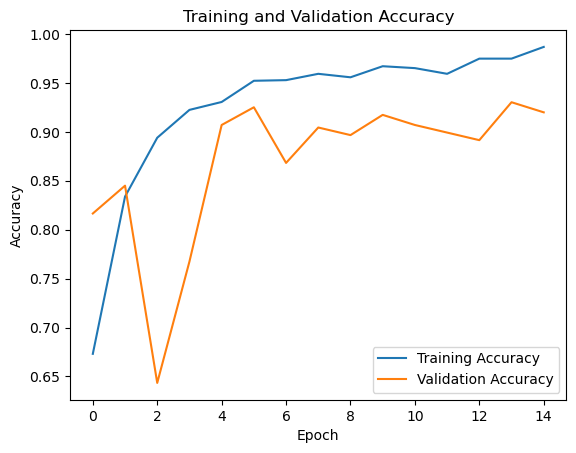

In [124]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy: 0.9147286821705426
AUC: 0.9583958020989505
Precision: 0.9037433155080213
Recall: 0.9184782608695652
Confusion Matrix:
[[185  18]
 [ 15 169]]


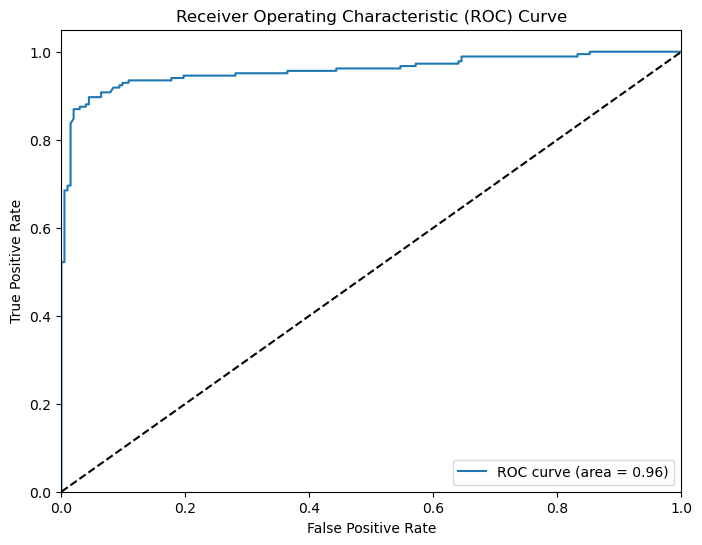

In [125]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1]) 
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

In [126]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3  # Import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Define input dimensions
img_height, img_width = 224, 224  

# Load InceptionV3 base model (pre-trained on ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")

Epoch 1/15
97/97 [==============================] - 132s 1s/step - loss: 1.1256 - accuracy: 0.6854 - val_loss: 0.5578 - val_accuracy: 0.7700
Epoch 2/15
97/97 [==============================] - 126s 1s/step - loss: 0.3632 - accuracy: 0.8361 - val_loss: 0.3646 - val_accuracy: 0.8527
Epoch 3/15
97/97 [==============================] - 127s 1s/step - loss: 0.2485 - accuracy: 0.8995 - val_loss: 0.2988 - val_accuracy: 0.8863
Epoch 4/15
97/97 [==============================] - 127s 1s/step - loss: 0.1618 - accuracy: 0.9415 - val_loss: 0.2841 - val_accuracy: 0.9018
Epoch 5/15
97/97 [==============================] - 126s 1s/step - loss: 0.1271 - accuracy: 0.9557 - val_loss: 0.2680 - val_accuracy: 0.9070
Epoch 6/15
97/97 [==============================] - 127s 1s/step - loss: 0.1123 - accuracy: 0.9567 - val_loss: 0.2726 - val_accuracy: 0.9251
Epoch 7/15
97/97 [==============================] - 127s 1s/step - loss: 0.0750 - accuracy: 0.9777 - val_loss: 0.2898 - val_accuracy: 0.9147
Epoch 8/15
97

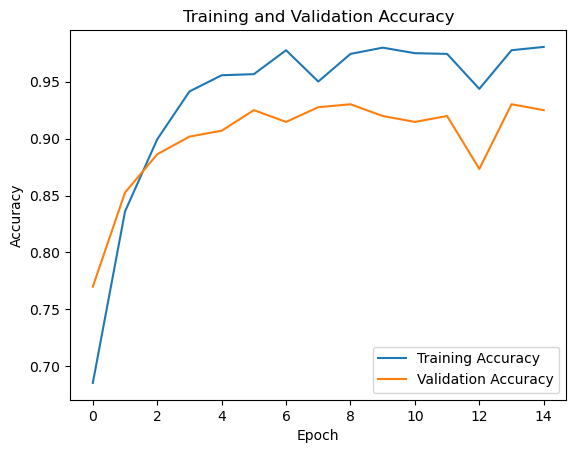

In [127]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step
Accuracy: 0.9328165374677002
AUC: 0.9559193617476978
Precision: 0.9540229885057471
Recall: 0.9021739130434783
Confusion Matrix:
[[195   8]
 [ 18 166]]


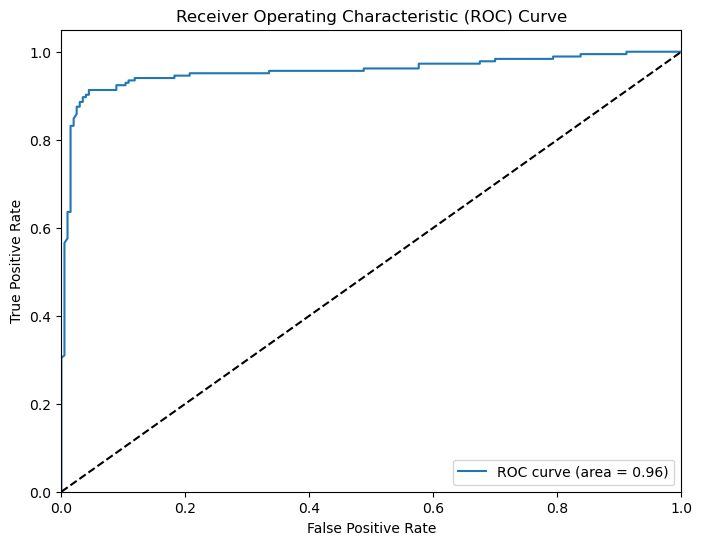

In [128]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

In [11]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3  # Import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

start_time = time.time()

# Define input dimensions
img_height, img_width = 224, 224  

# Load InceptionV3 base model (pre-trained on ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# End time measurement
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time
print("Processing time:", processing_time, "seconds")



Epoch 1/25


97/97 [==============================] - 145s 1s/step - loss: 1.0512 - accuracy: 0.6735 - val_loss: 0.5005 - val_accuracy: 0.7339
Epoch 2/25
97/97 [==============================] - 202s 2s/step - loss: 0.3745 - accuracy: 0.8358 - val_loss: 0.3749 - val_accuracy: 0.8553
Epoch 3/25
97/97 [==============================] - 187s 2s/step - loss: 0.2802 - accuracy: 0.8907 - val_loss: 0.3350 - val_accuracy: 0.8734
Epoch 4/25
97/97 [==============================] - 187s 2s/step - loss: 0.2108 - accuracy: 0.9247 - val_loss: 0.2924 - val_accuracy: 0.8992
Epoch 5/25
97/97 [==============================] - 199s 2s/step - loss: 0.1530 - accuracy: 0.9499 - val_loss: 0.2846 - val_accuracy: 0.9147
Epoch 6/25
97/97 [==============================] - 181s 2s/step - loss: 0.1276 - accuracy: 0.9583 - val_loss: 0.2674 - val_accuracy: 0.9199
Epoch 7/25
97/97 [==============================] - 181s 2s/step - loss: 0.1247 - accuracy: 0.9570 - val_loss: 0.3287 - val_accuracy: 0.8992
Epoch 8/2

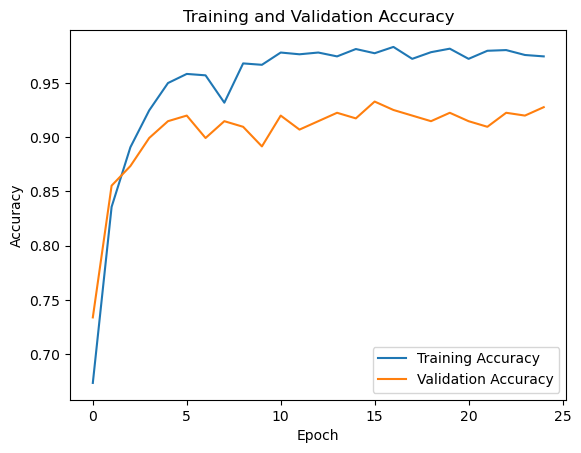

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step
Accuracy: 0.9224806201550387
AUC: 0.9541390019276076
Precision: 0.9425287356321839
Recall: 0.8913043478260869
Confusion Matrix:
[[193  10]
 [ 20 164]]


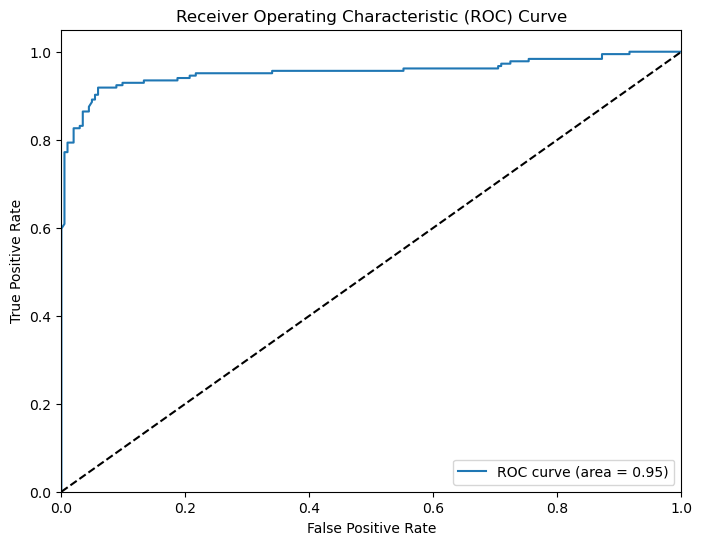

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)